# The Convolutional Classifier

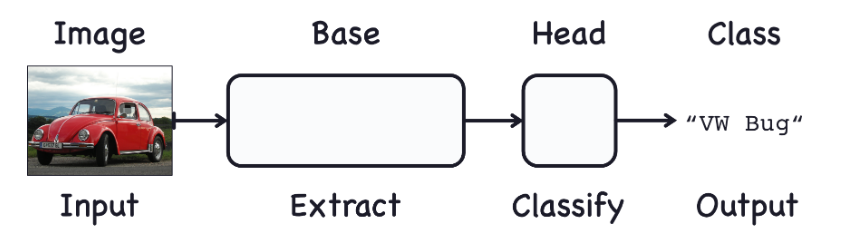

# 1.Load Data

In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec #?

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Reproducability (tensorflow seed 고정)
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) #os.environ = 환경 변수 읽어오기
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

In [3]:
# Set Matplotlib defaults
# rc ~ run configuration (실행 / 환경설정)
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large', 
      titleweight = 'bold', titlesize = 18, titlepad = 10)
plt.rc('image', cmap = 'magma')
warnings.filterwarnings("ignore")# to clean up output cells

In [4]:
ds_train_ = image_dataset_from_directory(
    'input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_valid_ = image_dataset_from_directory(
    'input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [5]:
#Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype = tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# 2. Define Pretrained Base
dataset from ImageNet, and using pretrained model called **VGG16** from it.

In [6]:
pretrained_base = tf.keras.models.load_model(
'input/cv-course-models/cv-course-models/vgg16-pretrained-base/')
pretrained_base.trainable = False

# 3. Attach Head
use a layer of hidden units (the first Dense layer) followed by a layer to transform the outputs to a probability score for class 1, Truck.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#모델 설정
model = Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')])

# 4. Train
- two class problem -> binary_crossentroy, binary accuracy used  
- The adam optimizer generally performs well

In [8]:
#모델 컴파일
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['binary_accuracy'])

In [ ]:
#모델 학습
history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=30,
                    verbose = 1
                   )

Epoch 1/30
80/80 [==============================] - 982s 12s/step - loss: 0.4994 - binary_accuracy: 0.7624 - val_loss: 0.4076 - val_binary_accuracy: 0.8278
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 0.3735 - binary_accuracy: 0.8440

The history object contains this information in a dictionary `history.history`. We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method.

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();